In [ ]:
#site = sites[0]
#copy_files(site)

gen_lr(site)

In [2]:
%%capture
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install fiona
!pip install geopandas
!pip install PyCRS
!pip install -i https://test.pypi.org/simple/ gis-utils-pkg-dillhicks==0.0.3

In [3]:
import rasterio
from shapely.geometry import box
import geopandas as gpd
from rasterio.mask import mask
from rasterio.plot import show
from tqdm.autonotebook import tqdm
import os
from rasterio import windows as wind
from fiona.crs import from_epsg
from gis_utils import raster
import matplotlib.pyplot as plt
import fiona
import numpy as np

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [4]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.2.0
Hub version: 0.8.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [112]:
#Function for getting files needed for data generation process from the drive
from os.path import join

def get_filelist():
    cur = []
    dest = "/content/drive/Shared drives/SIO and E4E Mangroves /Data/Machine Learning/Training Images/Hybrid CNN/"

    #horrible search method, do not do this, only works because how we specifically set up the drive structure

    #iterating through all files in orthomosaics directory
    for root, dirs, files in os.walk("/content/drive/Shared drives/SIO and E4E Mangroves /Data/Orthomosaics/"):
        for file in files:
            #finding all normal tifs
            if not(("dem" in file) or ("DEM" in file) or ("downsampled" in file) or ("CNN_prob" in file) or ("planetscope" in file) or ("kompsat" in file)) and not(file.startswith("un_")) and not(file.endswith("CNN_nm.tif")) and not(file.endswith("CNN_m.tif")) and not(file.startswith("prob_"))  and  (file.endswith(".tif")):
                #detecting planetscope images
                for ortho in os.listdir(root):
                    if ("planetscope" in ortho):

                        #get shapefiles from classifications folder
                        for subroot, subdirs, subfiles in os.walk(root):
                            zero = "0.shp"
                            one = "1.shp"

                            #iterating through files in 
                            for subfile in subfiles:
                                if (subfile == zero) or (subfile == one):
                                    dest_zip = join(dest,os.path.splitext(file)[0] + ".zip")
                                    #since we will get dupicates
                                    file_list = [join(root,file),
                                                    join(root,ortho),
                                                    join(subroot,zero),
                                                    join(subroot,one),
                                                    dest_zip]
                                    if not(file_list in cur):
                                        cur.append(file_list)
                                    



    return cur

In [42]:
def write_ndvi(image_file):
    np.seterr(divide='ignore', invalid='ignore')
    p_img, p_meta = raster.load_image(image_file)

    red = p_img.read(1)
    nir = p_img.read(4)
    array = p_img.read()
    ndvi = (nir - red)/(nir + red)
    show(ndvi)
    p_meta.update({"count": p_img.count+1})
    out_img = np.concatenate((array, np.expand_dims(ndvi, axis=0)))

    with rasterio.open(image_file, 'w', **p_meta) as outds:
        outds.write(out_img)

In [43]:
def write_ndwi(image_file):
    np.seterr(divide='ignore', invalid='ignore')
    p_img, p_meta = raster.load_image(image_file)

    green = p_img.read(2)
    nir = p_img.read(4)
    array = p_img.read()
    ndwi = (green - nir)/(nir + green)
    show(ndwi)
    p_meta.update({"count": p_img.count+1})
    out_img = np.concatenate((array, np.expand_dims(ndwi, axis=0)))

    with rasterio.open(image_file, 'w', **p_meta) as outds:
        outds.write(out_img)

In [44]:
def write_vari(image_file):
    np.seterr(divide='ignore', invalid='ignore')
    p_img, p_meta = raster.load_image(image_file)

    red = p_img.read(1)
    green = p_img.read(2)
    blue = p_img.read(3)
    array = p_img.read()
    vari = (green - red)/(green + red - blue)
    show(vari)
    p_meta.update({"count": p_img.count+1})
    out_img = np.concatenate((array, np.expand_dims(vari, axis=0)))

    with rasterio.open(image_file, 'w', **p_meta) as outds:
        outds.write(out_img)

In [7]:
#for clipping raster files

def clip(shp_file, image_file, str_format):
    with fiona.open(shp_file, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    with rasterio.open(image_file) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    with rasterio.open(str_format + image_file, "w", **out_meta) as dest:
        dest.write(out_image)

In [8]:
# for copying files over from google drive to 
def copy_files(file_list):
    print("Copying Files")

    !cp {"\"" + file_list[0] + "\"" } .
    !cp {"\"" + file_list[1] + "\"" } .

    d_name = os.path.basename(file_list[0])
    p_name = os.path.basename(file_list[1])

    !mv {d_name} /content/drone.tif
    !mv {p_name} /content/planetscope.tif

    !rm -rf /content/0/
    !rm -rf /content/1/ 

    !rm -rf /content/0_hr/
    !rm -rf /content/1_hr/

    !mkdir 0
    !mkdir 1
    !mkdir 0_hr
    !mkdir 1_hr

In [65]:
def clip_retile(file_list, width):
    print("Clipping and pixelizing drone data")

    d_img, d_meta = raster.load_image("/content/drone.tif")
    zero_gpd = gpd.read_file(file_list[2])
    one_gpd = gpd.read_file(file_list[3])

    
    clip(file_list[2], "drone.tif", "clipped0_")
    clip(file_list[3], "drone.tif", "clipped1_")

    !gdal_retile.py -ps {width} {width} -targetDir "/content/0_hr" "clipped0_drone.tif"
    !gdal_retile.py -ps {width} {width} -targetDir "/content/1_hr" "clipped1_drone.tif"

    remove_zero("/content/0_hr/")
    remove_zero("/content/1_hr/")

In [10]:
#for removing tiles created 
def remove_zero(img_dir):
    for filename in tqdm(os.listdir(img_dir)):
        filepath = os.path.join(img_dir, filename)
        tile, meta = raster.load_image(filepath)
        if np.array_equal(np.unique(np.array(tile.read())), [0.]):
            os.remove(filepath)

In [16]:
#getting features from the gdf for rasterio
from os.path import join

def getFeatures(gdf):

    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [109]:
def transfer_tiles(img, meta, tile_path, output_path):
    out_meta = meta
    output_filename = 'lr_{}.tif'
    d_bbox = box(img.bounds.left, img.bounds.bottom, img.bounds.right, img.bounds.top)

    for root, dirs, files in os.walk(tile_path):
        for file in tqdm(files):
            name = os.path.splitext(file)[0]
            dataset, _ = raster.load_image(join(root,file))
            bounds = dataset.bounds
            bbox = box(bounds.left, bounds.bottom, bounds.right, bounds.top)

            if bbox.within(d_bbox):
                geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
                geo = geo.to_crs(crs=dataset.crs.data)
                coords = getFeatures(geo)
                out_img, out_transform = mask(img, shapes=coords, crop=True, all_touched=True, filled=True)
                out_meta.update({"driver": "GTiff",
                        "height": out_img.shape[0],
                        "width": out_img.shape[1],
                        "transform": out_transform, 
                        "crs": from_epsg(4326)})
                outpath = os.path.join(output_path, output_filename.format(name))
                with rasterio.open(outpath, 'w', **out_meta) as outds:
                    outds.write(out_img)
            

In [12]:
#for removing tiles created 
def show_pixels(img_dir):
    for filename in tqdm(os.listdir(img_dir)):
        filepath = os.path.join(img_dir, filename)
        tile, out_meta = raster.load_image(filepath)
    return tile, filepath
        

In [69]:
def gen_lr():
    p_img, p_meta = raster.load_image("/content/planetscope.tif")
    transfer_tiles(p_img, p_meta, "/content/1_hr", "/content/1")
    transfer_tiles(p_img, p_meta, "/content/0_hr", "/content/0")

In [157]:
def gen_objects():

    from scipy.stats import describe

    image_dir = ["/content/0","/content/1"]
    for dir in image_dir:
        for file in tqdm(os.listdir(dir)):
            if (file.endswith(".tif") and ("lr" in file)):
                file_path = os.path.join(dir, file)
                img, out_meta = raster.load_image(file_path)
                out_transform = img.transform
                array  = img.read()
                flattened = np.reshape(array, (array.shape[0], array.shape[1]*array.shape[2]))

                stats = describe(flattened, axis = 1)

                features = np.asarray(list(stats.minmax) + list(stats)[2:]).flatten()

                out_img = np.expand_dims(np.expand_dims(features, axis = 1), axis = 2)

                out_meta.update({"driver": "GTiff",
                        "height": 1,
                        "width": 1,
                        "transform": out_transform, 
                        "crs": from_epsg(4326),
                        "count": features.shape[0]})
                with rasterio.open(file_path, 'w', **out_meta) as outds:
                    outds.write(out_img)

In [158]:
def upload(file_list):
    !zip {"\"" + file_list[4] + "\""} -r 0 0_hr 1 1_hr
    !rm -rf *.tif
    !rm -rf *.shp

Copying Files


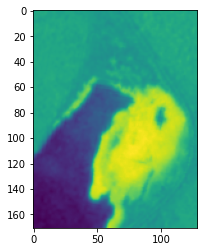

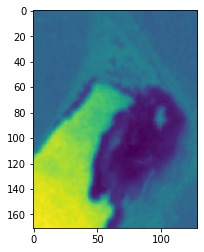

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Streaming output truncated to the last 5000 lines.
  adding: 1_hr/clipped1_drone_027_044.tif (deflated 44%)
  adding: 1_hr/clipped1_drone_108_050.tif (deflated 91%)
  adding: 1_hr/clipped1_drone_114_039.tif (deflated 35%)
  adding: 1_hr/clipped1_drone_094_032.tif (deflated 33%)
  adding: 1_hr/clipped1_drone_016_031.tif (deflated 36%)
  adding: 1_hr/clipped1_drone_124_022.tif (deflated 92%)
  adding: 1_hr/clipped1_drone_010_060.tif (deflated 29%)
  adding: 1_hr/clipped1_drone_024_059.tif (deflated 22%)
  adding: 1_hr/clipped1_drone_044_068.tif (deflated 97%)
  adding: 1_hr/clipped1_drone_038_054.tif (deflated 28%)
  adding: 1_hr/clipped1_drone_053_008.tif (deflated 47%)
  adding: 1_hr/clipped1_drone_055_030.tif (deflated 35%)
  adding: 1_hr/clipped1_drone_053_029.tif (deflated 34%)
  adding: 1_hr/clipped1_drone_035_048.tif (deflated 39%)
  adding: 1_hr/clipped1_drone_059_022.tif (deflated 75%)
  adding: 1_hr/clipped1_drone_029_074.tif (deflated 35%)
  adding: 1_hr/clipped1_drone_124_059

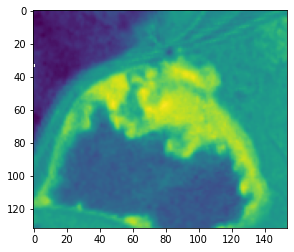

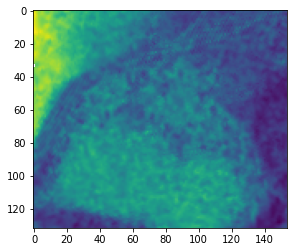

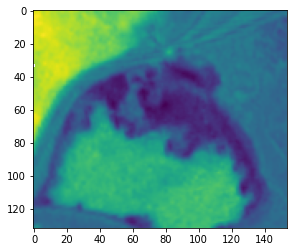

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


Streaming output truncated to the last 5000 lines.
updating: 1_hr/clipped1_drone_005_081.tif (deflated 50%)
updating: 1_hr/clipped1_drone_044_022.tif (deflated 76%)
updating: 1_hr/clipped1_drone_018_037.tif (deflated 47%)
updating: 1_hr/clipped1_drone_014_084.tif (deflated 37%)
updating: 1_hr/clipped1_drone_085_050.tif (deflated 56%)
updating: 1_hr/clipped1_drone_064_082.tif (deflated 62%)
updating: 1_hr/clipped1_drone_007_070.tif (deflated 54%)
updating: 1_hr/clipped1_drone_086_059.tif (deflated 57%)
updating: 1_hr/clipped1_drone_037_085.tif (deflated 54%)
updating: 1_hr/clipped1_drone_075_071.tif (deflated 54%)
updating: 1_hr/clipped1_drone_072_091.tif (deflated 50%)
updating: 1_hr/clipped1_drone_055_109.tif (deflated 80%)
updating: 1_hr/clipped1_drone_073_082.tif (deflated 56%)
updating: 1_hr/clipped1_drone_051_097.tif (deflated 51%)
updating: 1_hr/clipped1_drone_007_054.tif (deflated 64%)
updating: 1_hr/clipped1_drone_049_067.tif (deflated 84%)
updating: 1_hr/clipped1_drone_047_090

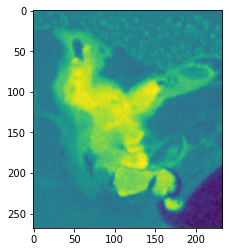

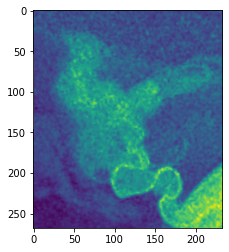

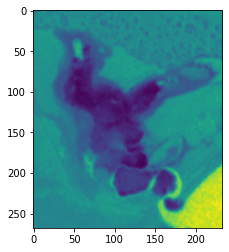

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


Streaming output truncated to the last 5000 lines.
  adding: 1_hr/clipped1_drone_036_025.tif (deflated 52%)
  adding: 1_hr/clipped1_drone_160_102.tif (deflated 39%)
  adding: 1_hr/clipped1_drone_033_131.tif (deflated 29%)
  adding: 1_hr/clipped1_drone_057_152.tif (deflated 36%)
  adding: 1_hr/clipped1_drone_184_141.tif (deflated 52%)
  adding: 1_hr/clipped1_drone_148_107.tif (deflated 54%)
  adding: 1_hr/clipped1_drone_107_109.tif (deflated 54%)
  adding: 1_hr/clipped1_drone_023_132.tif (deflated 36%)
  adding: 1_hr/clipped1_drone_141_105.tif (deflated 27%)
  adding: 1_hr/clipped1_drone_117_100.tif (deflated 30%)
  adding: 1_hr/clipped1_drone_066_011.tif (deflated 51%)
  adding: 1_hr/clipped1_drone_183_101.tif (deflated 33%)
  adding: 1_hr/clipped1_drone_135_118.tif (deflated 21%)
  adding: 1_hr/clipped1_drone_046_064.tif (deflated 48%)
  adding: 1_hr/clipped1_drone_168_131.tif (deflated 37%)
  adding: 1_hr/clipped1_drone_120_084.tif (deflated 76%)
  adding: 1_hr/clipped1_drone_145_059

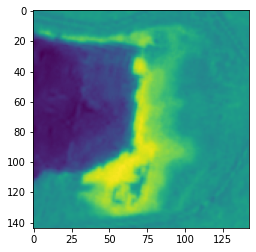

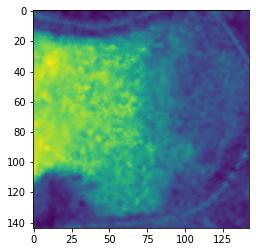

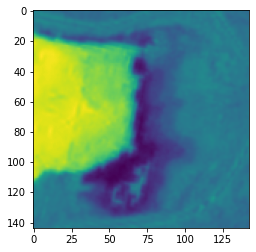

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


Streaming output truncated to the last 5000 lines.
  adding: 1_hr/clipped1_drone_050_072.tif (deflated 67%)
  adding: 1_hr/clipped1_drone_056_019.tif (deflated 39%)
  adding: 1_hr/clipped1_drone_003_057.tif (deflated 73%)
  adding: 1_hr/clipped1_drone_081_050.tif (deflated 57%)
  adding: 1_hr/clipped1_drone_043_047.tif (deflated 46%)
  adding: 1_hr/clipped1_drone_070_064.tif (deflated 95%)
  adding: 1_hr/clipped1_drone_093_023.tif (deflated 43%)
  adding: 1_hr/clipped1_drone_025_026.tif (deflated 49%)
  adding: 1_hr/clipped1_drone_015_044.tif (deflated 98%)
  adding: 1_hr/clipped1_drone_073_090.tif (deflated 38%)
  adding: 1_hr/clipped1_drone_096_066.tif (deflated 46%)
  adding: 1_hr/clipped1_drone_074_011.tif (deflated 50%)
  adding: 1_hr/clipped1_drone_051_047.tif (deflated 49%)
  adding: 1_hr/clipped1_drone_038_040.tif (deflated 53%)
  adding: 1_hr/clipped1_drone_046_087.tif (deflated 44%)
  adding: 1_hr/clipped1_drone_098_042.tif (deflated 50%)
  adding: 1_hr/clipped1_drone_018_030

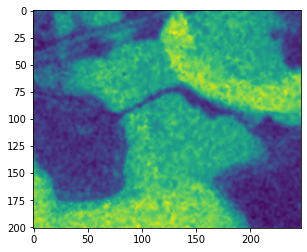

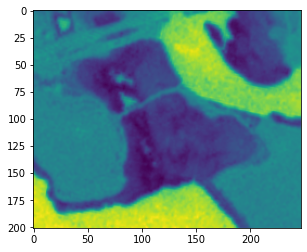

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


Streaming output truncated to the last 5000 lines.
  adding: 1_hr/clipped1_drone_038_097.tif (deflated 26%)
  adding: 1_hr/clipped1_drone_134_084.tif (deflated 49%)
  adding: 1_hr/clipped1_drone_034_120.tif (deflated 65%)
  adding: 1_hr/clipped1_drone_064_136.tif (deflated 52%)
  adding: 1_hr/clipped1_drone_076_026.tif (deflated 33%)
  adding: 1_hr/clipped1_drone_067_024.tif (deflated 29%)
  adding: 1_hr/clipped1_drone_124_088.tif (deflated 45%)
  adding: 1_hr/clipped1_drone_039_111.tif (deflated 45%)
  adding: 1_hr/clipped1_drone_116_043.tif (deflated 42%)
  adding: 1_hr/clipped1_drone_085_172.tif (deflated 29%)
  adding: 1_hr/clipped1_drone_123_096.tif (deflated 51%)
  adding: 1_hr/clipped1_drone_045_003.tif (deflated 45%)
  adding: 1_hr/clipped1_drone_057_075.tif (deflated 35%)
  adding: 1_hr/clipped1_drone_056_106.tif (deflated 52%)
  adding: 1_hr/clipped1_drone_128_135.tif (deflated 31%)
  adding: 1_hr/clipped1_drone_122_146.tif (deflated 44%)
  adding: 1_hr/clipped1_drone_131_115

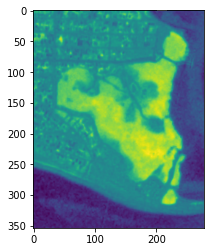

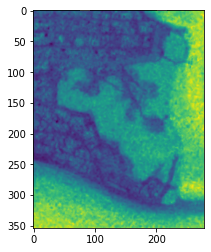

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


Streaming output truncated to the last 5000 lines.
  adding: 1_hr/clipped1_drone_068_028.tif (deflated 35%)
  adding: 1_hr/clipped1_drone_203_112.tif (deflated 54%)
  adding: 1_hr/clipped1_drone_050_161.tif (deflated 97%)
  adding: 1_hr/clipped1_drone_230_147.tif (deflated 42%)
  adding: 1_hr/clipped1_drone_169_096.tif (deflated 25%)
  adding: 1_hr/clipped1_drone_069_051.tif (deflated 99%)
  adding: 1_hr/clipped1_drone_001_158.tif (deflated 79%)
  adding: 1_hr/clipped1_drone_152_093.tif (deflated 29%)
  adding: 1_hr/clipped1_drone_100_154.tif (deflated 49%)
  adding: 1_hr/clipped1_drone_174_086.tif (deflated 24%)
  adding: 1_hr/clipped1_drone_067_034.tif (deflated 37%)
  adding: 1_hr/clipped1_drone_120_104.tif (deflated 26%)
  adding: 1_hr/clipped1_drone_075_091.tif (deflated 27%)
  adding: 1_hr/clipped1_drone_236_163.tif (deflated 67%)
  adding: 1_hr/clipped1_drone_057_183.tif (deflated 56%)
  adding: 1_hr/clipped1_drone_166_094.tif (deflated 33%)
  adding: 1_hr/clipped1_drone_047_137

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


Streaming output truncated to the last 5000 lines.
  adding: 1_hr/clipped1_drone_148_038.tif (deflated 44%)
  adding: 1_hr/clipped1_drone_137_062.tif (deflated 80%)
  adding: 1_hr/clipped1_drone_016_022.tif (deflated 59%)
  adding: 1_hr/clipped1_drone_099_015.tif (deflated 59%)
  adding: 1_hr/clipped1_drone_107_047.tif (deflated 43%)
  adding: 1_hr/clipped1_drone_010_007.tif (deflated 52%)
  adding: 1_hr/clipped1_drone_022_026.tif (deflated 66%)
  adding: 1_hr/clipped1_drone_114_025.tif (deflated 87%)
  adding: 1_hr/clipped1_drone_043_054.tif (deflated 36%)
  adding: 1_hr/clipped1_drone_016_039.tif (deflated 33%)
  adding: 1_hr/clipped1_drone_011_005.tif (deflated 41%)
  adding: 1_hr/clipped1_drone_129_011.tif (deflated 58%)
  adding: 1_hr/clipped1_drone_029_027.tif (deflated 33%)
  adding: 1_hr/clipped1_drone_066_012.tif (deflated 39%)
  adding: 1_hr/clipped1_drone_005_050.tif (deflated 45%)
  adding: 1_hr/clipped1_drone_149_017.tif (deflated 40%)
  adding: 1_hr/clipped1_drone_068_043

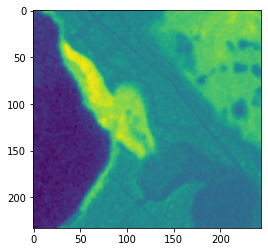

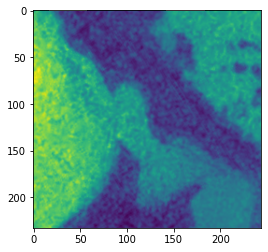

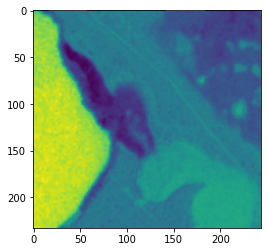

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


Streaming output truncated to the last 5000 lines.
  adding: 1_hr/clipped1_drone_123_132.tif (deflated 58%)
  adding: 1_hr/clipped1_drone_032_010.tif (deflated 27%)
  adding: 1_hr/clipped1_drone_106_047.tif (deflated 38%)
  adding: 1_hr/clipped1_drone_104_071.tif (deflated 42%)
  adding: 1_hr/clipped1_drone_095_115.tif (deflated 41%)
  adding: 1_hr/clipped1_drone_116_155.tif (deflated 49%)
  adding: 1_hr/clipped1_drone_108_053.tif (deflated 41%)
  adding: 1_hr/clipped1_drone_033_066.tif (deflated 58%)
  adding: 1_hr/clipped1_drone_119_166.tif (deflated 34%)
  adding: 1_hr/clipped1_drone_005_041.tif (deflated 99%)
  adding: 1_hr/clipped1_drone_108_113.tif (deflated 36%)
  adding: 1_hr/clipped1_drone_076_097.tif (deflated 41%)
  adding: 1_hr/clipped1_drone_071_103.tif (deflated 40%)
  adding: 1_hr/clipped1_drone_119_088.tif (deflated 34%)
  adding: 1_hr/clipped1_drone_144_093.tif (deflated 31%)
  adding: 1_hr/clipped1_drone_141_104.tif (deflated 27%)
  adding: 1_hr/clipped1_drone_149_107

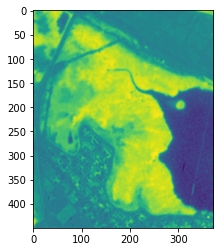

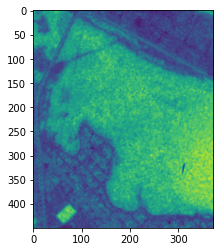

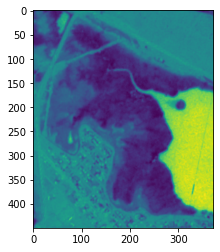

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


Streaming output truncated to the last 5000 lines.
  adding: 1_hr/clipped1_drone_264_144.tif (deflated 35%)
  adding: 1_hr/clipped1_drone_127_137.tif (deflated 93%)
  adding: 1_hr/clipped1_drone_123_008.tif (deflated 45%)
  adding: 1_hr/clipped1_drone_204_159.tif (deflated 80%)
  adding: 1_hr/clipped1_drone_031_094.tif (deflated 92%)
  adding: 1_hr/clipped1_drone_220_158.tif (deflated 93%)
  adding: 1_hr/clipped1_drone_183_067.tif (deflated 55%)
  adding: 1_hr/clipped1_drone_278_134.tif (deflated 64%)
  adding: 1_hr/clipped1_drone_093_245.tif (deflated 38%)
  adding: 1_hr/clipped1_drone_133_017.tif (deflated 34%)
  adding: 1_hr/clipped1_drone_183_064.tif (deflated 81%)
  adding: 1_hr/clipped1_drone_066_162.tif (deflated 35%)
  adding: 1_hr/clipped1_drone_070_058.tif (deflated 37%)
  adding: 1_hr/clipped1_drone_226_094.tif (deflated 93%)
  adding: 1_hr/clipped1_drone_229_191.tif (deflated 53%)
  adding: 1_hr/clipped1_drone_105_209.tif (deflated 98%)
  adding: 1_hr/clipped1_drone_080_217

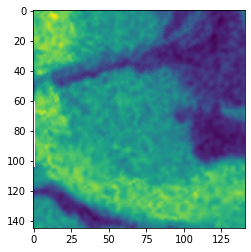

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


Streaming output truncated to the last 5000 lines.
  adding: 1_hr/clipped1_drone_071_093.tif (deflated 59%)
  adding: 1_hr/clipped1_drone_015_070.tif (deflated 47%)
  adding: 1_hr/clipped1_drone_033_099.tif (deflated 33%)
  adding: 1_hr/clipped1_drone_088_070.tif (deflated 64%)
  adding: 1_hr/clipped1_drone_066_009.tif (deflated 64%)
  adding: 1_hr/clipped1_drone_039_083.tif (deflated 34%)
  adding: 1_hr/clipped1_drone_068_025.tif (deflated 65%)
  adding: 1_hr/clipped1_drone_088_045.tif (deflated 62%)
  adding: 1_hr/clipped1_drone_013_068.tif (deflated 41%)
  adding: 1_hr/clipped1_drone_063_018.tif (deflated 50%)
  adding: 1_hr/clipped1_drone_086_100.tif (deflated 64%)
  adding: 1_hr/clipped1_drone_045_078.tif (deflated 39%)
  adding: 1_hr/clipped1_drone_055_006.tif (deflated 64%)
  adding: 1_hr/clipped1_drone_047_036.tif (deflated 58%)
  adding: 1_hr/clipped1_drone_096_080.tif (deflated 61%)
  adding: 1_hr/clipped1_drone_082_089.tif (deflated 65%)
  adding: 1_hr/clipped1_drone_104_057

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


Streaming output truncated to the last 5000 lines.
  adding: 1_hr/clipped1_drone_017_119.tif (deflated 39%)
  adding: 1_hr/clipped1_drone_141_243.tif (deflated 55%)
  adding: 1_hr/clipped1_drone_109_183.tif (deflated 46%)
  adding: 1_hr/clipped1_drone_112_068.tif (deflated 43%)
  adding: 1_hr/clipped1_drone_086_110.tif (deflated 37%)
  adding: 1_hr/clipped1_drone_027_032.tif (deflated 48%)
  adding: 1_hr/clipped1_drone_102_055.tif (deflated 37%)
  adding: 1_hr/clipped1_drone_111_068.tif (deflated 37%)
  adding: 1_hr/clipped1_drone_144_205.tif (deflated 41%)
  adding: 1_hr/clipped1_drone_068_198.tif (deflated 99%)
  adding: 1_hr/clipped1_drone_072_107.tif (deflated 35%)
  adding: 1_hr/clipped1_drone_087_052.tif (deflated 56%)
  adding: 1_hr/clipped1_drone_144_148.tif (deflated 93%)
  adding: 1_hr/clipped1_drone_098_132.tif (deflated 69%)
  adding: 1_hr/clipped1_drone_071_128.tif (deflated 48%)
  adding: 1_hr/clipped1_drone_052_050.tif (deflated 32%)
  adding: 1_hr/clipped1_drone_020_040

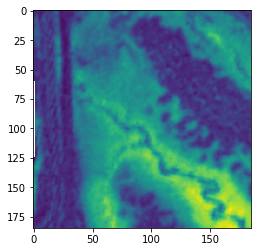

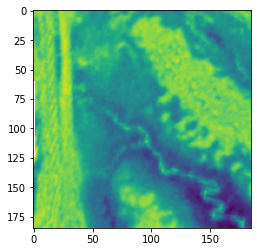

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


Streaming output truncated to the last 5000 lines.
  adding: 1_hr/clipped1_drone_100_044.tif (deflated 62%)
  adding: 1_hr/clipped1_drone_074_098.tif (deflated 47%)
  adding: 1_hr/clipped1_drone_081_021.tif (deflated 47%)
  adding: 1_hr/clipped1_drone_083_021.tif (deflated 40%)
  adding: 1_hr/clipped1_drone_008_045.tif (deflated 48%)
  adding: 1_hr/clipped1_drone_073_020.tif (deflated 41%)
  adding: 1_hr/clipped1_drone_068_074.tif (deflated 38%)
  adding: 1_hr/clipped1_drone_060_053.tif (deflated 89%)
  adding: 1_hr/clipped1_drone_060_103.tif (deflated 46%)
  adding: 1_hr/clipped1_drone_117_071.tif (deflated 51%)
  adding: 1_hr/clipped1_drone_075_082.tif (deflated 40%)
  adding: 1_hr/clipped1_drone_085_036.tif (deflated 65%)
  adding: 1_hr/clipped1_drone_105_073.tif (deflated 76%)
  adding: 1_hr/clipped1_drone_073_084.tif (deflated 42%)
  adding: 1_hr/clipped1_drone_105_023.tif (deflated 46%)
  adding: 1_hr/clipped1_drone_115_051.tif (deflated 40%)
  adding: 1_hr/clipped1_drone_060_109

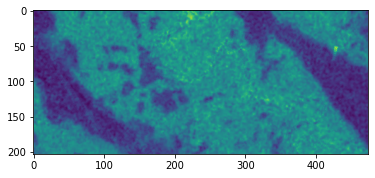

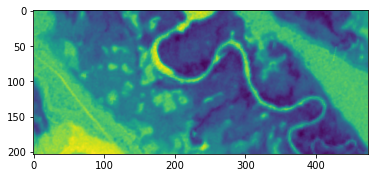

Clipping and pixelizing satellite data
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


Streaming output truncated to the last 5000 lines.
  adding: 1_hr/clipped1_drone_025_229.tif (deflated 84%)
  adding: 1_hr/clipped1_drone_028_224.tif (deflated 39%)
  adding: 1_hr/clipped1_drone_129_140.tif (deflated 42%)
  adding: 1_hr/clipped1_drone_010_114.tif (deflated 56%)
  adding: 1_hr/clipped1_drone_018_228.tif (deflated 32%)
  adding: 1_hr/clipped1_drone_119_084.tif (deflated 43%)
  adding: 1_hr/clipped1_drone_053_205.tif (deflated 50%)
  adding: 1_hr/clipped1_drone_086_150.tif (deflated 99%)
  adding: 1_hr/clipped1_drone_065_277.tif (deflated 28%)
  adding: 1_hr/clipped1_drone_074_051.tif (deflated 91%)
  adding: 1_hr/clipped1_drone_034_099.tif (deflated 84%)
  adding: 1_hr/clipped1_drone_022_007.tif (deflated 44%)
  adding: 1_hr/clipped1_drone_083_130.tif (deflated 47%)
  adding: 1_hr/clipped1_drone_117_144.tif (deflated 82%)
  adding: 1_hr/clipped1_drone_028_214.tif (deflated 52%)
  adding: 1_hr/clipped1_drone_094_292.tif (deflated 30%)
  adding: 1_hr/clipped1_drone_070_138

In [160]:
for site in get_filelist():
    copy_files(site)
    write_ndvi("planetscope.tif")
    write_vari("planetscope.tif")
    write_ndwi("planetscope.tif")
    clip_retile(site,128)
    gen_lr()
    gen_objects()
    upload(site)